In [2]:
import pandas as pd

# CARGA DE DATOS CSV
cafetera_df = pd.read_csv('analisis_de_datos/cafetera.csv')
licuadora_df = pd.read_csv('analisis_de_datos/licuadora.csv')
esmeril_df = pd.read_csv('analisis_de_datos/esmeril.csv')
microondas_df = pd.read_csv('analisis_de_datos/microondas.csv')

# AGREGAR COLUMNA DE ETIQUETA POR CADA DISPOSITIVO
cafetera_df['dispositivo'] = 'cafetera'
licuadora_df['dispositivo'] = 'licuadora'
esmeril_df['dispositivo'] = 'esmeril'
microondas_df['dispositivo'] = 'microondas'

# COMBINAR DATO EN UN SOLO DATAFRAME
datos_combinados = pd.concat([cafetera_df, licuadora_df, esmeril_df, microondas_df])

# GUARDAR ARCHIVO
datos_combinados.to_csv('datos_combinados.csv', index=False)

print(datos_combinados.head())

                 fecha  valor_corriente dispositivo
0  2024-08-16_08-42-01         0.063589    cafetera
1  2024-08-16_08-42-06         7.753287    cafetera
2  2024-08-16_08-42-08         7.720316    cafetera
3  2024-08-16_08-42-10         7.723514    cafetera
4  2024-08-16_08-42-12         7.691499    cafetera


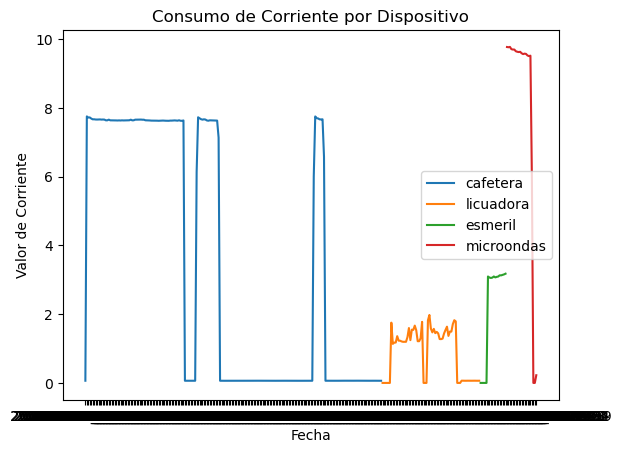

In [3]:
import matplotlib.pyplot as plt

#VISUALIZACION DE CONSUMO POR CADA DISPOSITIVO
for dispositivo in datos_combinados['dispositivo'].unique():
    subset = datos_combinados[datos_combinados['dispositivo'] == dispositivo]
    plt.plot(subset['fecha'], subset['valor_corriente'], label=dispositivo)

plt.xlabel('Fecha')
plt.ylabel('Valor de Corriente')
plt.title('Consumo de Corriente por Dispositivo')
plt.legend()
plt.show()


In [4]:
#EXTRACCION DE CARACTERISTICAS DE CADA DISPOSITIVO, MEDIA, DESVIACION Y PICOS

# Calcular características estadísticas de corriente
def extraer_caracteristicas(df):
    df['media_corriente'] = df['valor_corriente'].rolling(window=5).mean()  # Media en una ventana de 5 muestras
    df['desviacion_corriente'] = df['valor_corriente'].rolling(window=5).std()  # Desviación estándar
    df['corriente_max'] = df['valor_corriente'].rolling(window=5).max()  # Corriente máxima
    df['corriente_min'] = df['valor_corriente'].rolling(window=5).min()  # Corriente mínima
    df = df.dropna()  # Elimina valores NaN generados por la ventana de tiempo
    return df

# Aplicar la extracción de características
datos_combinados = extraer_caracteristicas(datos_combinados)

# Selección de características y etiquetas
X = datos_combinados[['media_corriente', 'desviacion_corriente', 'corriente_max', 'corriente_min']]
y = datos_combinados['dispositivo']

In [5]:
#DIVISION DE DATOS

from sklearn.model_selection import train_test_split

# Dividir los datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

[[39  0  0  0]
 [ 0  3  0  0]
 [ 0  0 14  0]
 [ 3  0  0  2]]
              precision    recall  f1-score   support

    cafetera       0.93      1.00      0.96        39
     esmeril       1.00      1.00      1.00         3
   licuadora       1.00      1.00      1.00        14
  microondas       1.00      0.40      0.57         5

    accuracy                           0.95        61
   macro avg       0.98      0.85      0.88        61
weighted avg       0.95      0.95      0.94        61



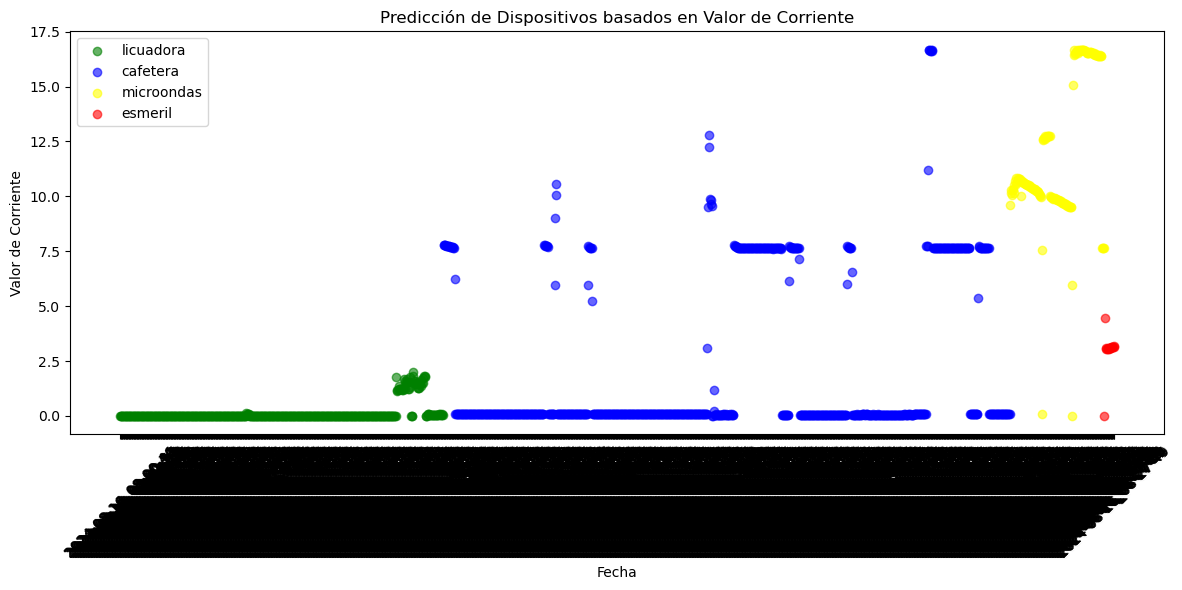

In [7]:
#ENTRENAMIENTO DEL MODELO RANDOM FOREST

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Crear el modelo de Random Forest
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
modelo_rf.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = modelo_rf.predict(X_test)

# Evaluar el modelo
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
#PREDICCION CON NUEVOS DATOS

# Cargar nuevos datos
datos_generales = pd.read_csv('corrientesGenerales.csv')

# Extraer características
datos_generales = extraer_caracteristicas(datos_generales)

# Predecir el dispositivo de cada registro
X_nuevos = datos_generales[['media_corriente', 'desviacion_corriente']]
predicciones = modelo_rf.predict(X_nuevos)

# Agregar las predicciones al DataFrame
datos_generales['dispositivo_predicho'] = predicciones

# Guardar los resultados en un archivo CSV
datos_generales.to_csv('datos_predicciones.csv', index=False)#VISUALIZACION
import matplotlib.pyplot as plt

# Configurar colores para cada dispositivo
colores = {'cafetera': 'blue', 'licuadora': 'green', 'esmeril':'red', 'microondas':'yellow'}

# Crear la gráfica de dispersión
plt.figure(figsize=(12, 6))
for dispositivo in datos_generales['dispositivo_predicho'].unique():
    subset = datos_generales[datos_generales['dispositivo_predicho'] == dispositivo]
    plt.scatter(subset['fecha'], subset['valor_corriente'], label=dispositivo, color=colores[dispositivo], alpha=0.6)

# Configurar etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Valor de Corriente')
plt.title('Predicción de Dispositivos basados en Valor de Corriente')
plt.xticks(rotation=45)
plt.legend()

# Mostrar la gráfica
plt.tight_layout()
plt.show()

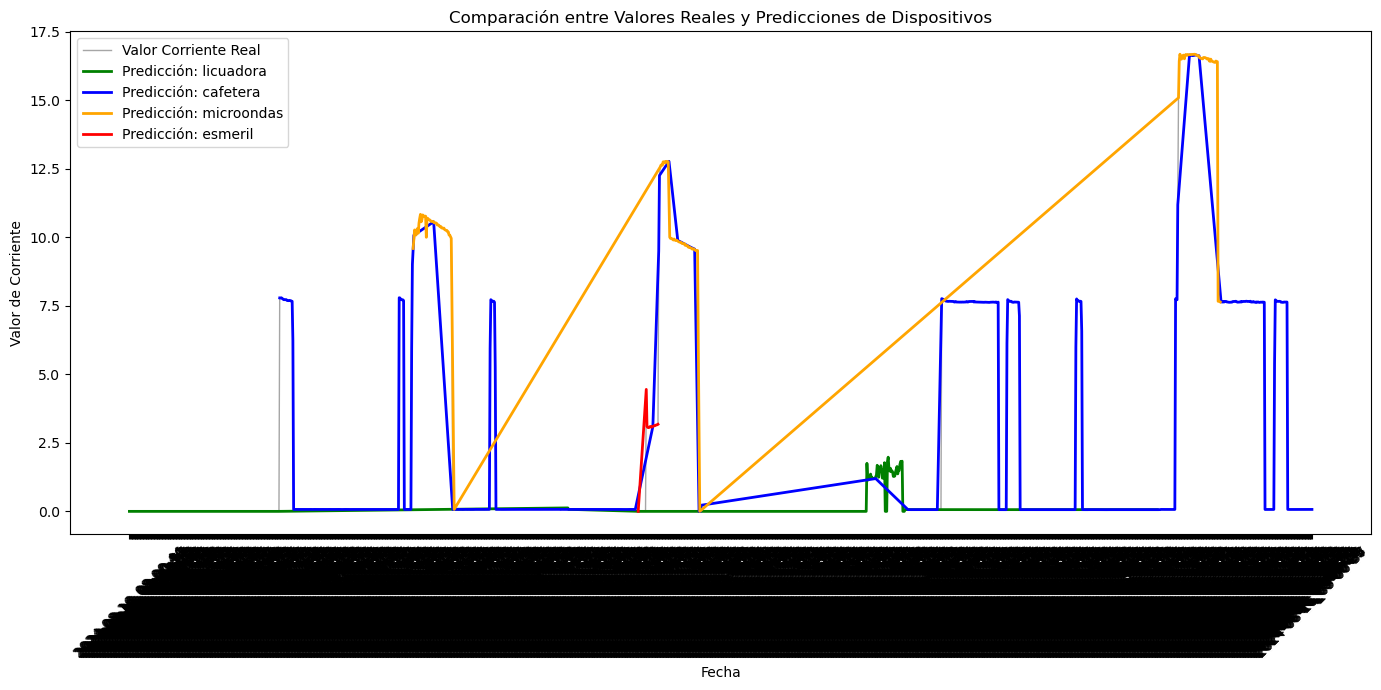

In [8]:
import matplotlib.pyplot as plt

# Configurar colores más fuertes para cada dispositivo
colores_prediccion = {'cafetera': 'blue', 'licuadora': 'green', 'esmeril': 'red', 'microondas': 'orange'}

# Crear la gráfica de líneas
plt.figure(figsize=(14, 7))

# Graficar las corrientes reales (sin etiqueta de dispositivo)
plt.plot(datos_generales['fecha'], datos_generales['valor_corriente'], label='Valor Corriente Real', color='gray', alpha=0.7, linewidth=1)

# Graficar las predicciones con colores más fuertes y líneas continuas
for dispositivo in datos_generales['dispositivo_predicho'].unique():
    subset = datos_generales[datos_generales['dispositivo_predicho'] == dispositivo]
    plt.plot(subset['fecha'], subset['valor_corriente'], label=f'Predicción: {dispositivo}', color=colores_prediccion[dispositivo], linewidth=2)

# Configurar etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Valor de Corriente')
plt.title('Comparación entre Valores Reales y Predicciones de Dispositivos')
plt.xticks(rotation=45)
plt.legend()

# Ajustar el diseño para que todo encaje
plt.tight_layout()

# Mostrar la gráfica
plt.show()
